In [134]:
#data handling & visualisation
import pandas as pd
import matplotlib.pyplot as plt

#data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#models & metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error,accuracy_score,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [75]:
matches = pd.read_csv("matches.csv")

#### Data preprocessing

chaning the values of the result column & venue column

In [76]:
matches['result'] = matches['result'].map({'W': 1,
                                 'D': 0,
                                 'L': -1})

matches['venue'] = matches['venue'].map({'Away': 0,
                                         'Home': 1})

In [77]:
#removing noise
matches.formation = matches.formation.str.replace("◆", "")
matches.formation = matches.formation.str.replace("-0", "")

In [78]:
#feature selection
features = ['venue', 'xg', 'xga', 'poss', 'formation', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
X = matches[features]
y = matches['result']

#splitting training & testing data
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [79]:
'''
    there are 20+ unique values in the formation column
    can't use ordinal encoding as there's no priority within each formation
    (even if there is this dataset doen't have enough data for it to have an effect)
    since it's too important to drop, I'm using one hot encoding
'''

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#one hot encoding the 'formation' column
encoded_train = pd.DataFrame(encoder.fit_transform(X_train[['formation']]))
encoded_valid = pd.DataFrame(encoder.transform(X_valid[['formation']]))

#matching the index
encoded_train.index = X_train.index
encoded_valid.index = X_valid.index

#dropping the 'formation' column from the test & validation set
formationL_X_train = X_train.drop('formation', axis=1)
formationL_X_valid = X_valid.drop('formation', axis=1)

#adding the encoded columns to the 'formation'-less datasets
encoded_X_train = pd.concat([formationL_X_train, encoded_train], axis=1)
encoded_X_valid = pd.concat([formationL_X_valid, encoded_valid], axis=1)

#setting the dtype
encoded_X_train.columns = encoded_X_train.columns.astype(str)
encoded_X_valid.columns = encoded_X_valid.columns.astype(str)

#### using Random Forest

In [98]:
#initiating & fitting the model
rf_model = RandomForestClassifier(n_estimators=10, random_state=0)
rf_model.fit(encoded_X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=0)

In [135]:
#predicting & testing
rf_prediction = rf_model.predict(encoded_X_valid)

# print(mean_absolute_error(y_valid, prediction))

#defininf metrics
rf_training_score = rf_model.score(encoded_X_train, y_train)
rf_testing_score = accuracy_score(y_valid, rf_prediction)

#printing scores
print("training: ", rf_training_score)
print("testing: ", rf_testing_score)
print(classification_report(y_valid, rf_prediction))

training:  0.9882506527415144
testing:  0.7223382045929019
              precision    recall  f1-score   support

          -1       0.73      0.80      0.76       379
           0       0.56      0.40      0.47       204
           1       0.78      0.82      0.80       375

    accuracy                           0.72       958
   macro avg       0.69      0.67      0.67       958
weighted avg       0.71      0.72      0.71       958



#### using Decision Trees

In [130]:
#model initiation & fitting
dt_model = DecisionTreeClassifier(min_samples_leaf=2, random_state=0)
dt_model.fit(encoded_X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=2, random_state=0)

In [131]:
#predicting & testing
dt_prediction = dt_model.predict(encoded_X_valid)

# print(mean_absolute_error(y_valid, prediction))

#defininf metrics
dt_training_score = dt_model.score(encoded_X_train, y_train)
dt_testing_score = accuracy_score(y_valid, dt_prediction)

#printing scores
print("training: ", dt_training_score)
print("testing: ", dt_testing_score)
print(classification_report(y_valid, dt_prediction))

training:  0.9156657963446475
testing:  0.6388308977035491
              precision    recall  f1-score   support

          -1       0.67      0.75      0.71       379
           0       0.40      0.45      0.42       204
           1       0.77      0.63      0.69       375

    accuracy                           0.64       958
   macro avg       0.61      0.61      0.61       958
weighted avg       0.65      0.64      0.64       958



#### scores

In [178]:
# create a dataframe with all the scores
scores_dict = {
    'TrainingScore': [rf_training_score, dt_training_score],
    'TestingScore': [rf_testing_score, dt_testing_score],
    'macro avg precision': [precision_score(y_valid, rf_prediction, average='macro'), precision_score(y_valid, dt_prediction, average='macro')],
    'macro avg recall': [recall_score(y_valid, rf_prediction, average='macro'), recall_score(y_valid, dt_prediction, average='macro')],
    'macro avg f1': [f1_score(y_valid, rf_prediction, average='macro'), f1_score(y_valid, dt_prediction, average='macro')],
    'weighted avg precision': [precision_score(y_valid, rf_prediction, average='weighted'), precision_score(y_valid, dt_prediction, average='weighted')],
    'weighted avg recall': [recall_score(y_valid, rf_prediction, average='weighted'), recall_score(y_valid, dt_prediction, average='weighted')],
    'weighted avg f1': [f1_score(y_valid, rf_prediction, average='weighted'), f1_score(y_valid, dt_prediction, average='weighted')]
}

scores_df = pd.DataFrame(scores_dict).transpose()
scores_df.columns = ['RandomForest', 'DecisionTree']

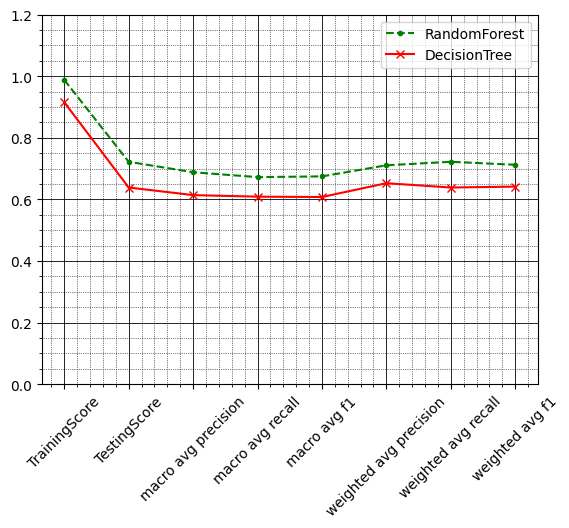

In [181]:
# ploting a graph of all the scores
plt.plot(scores_df.RandomForest, 'g.--', label='RandomForest')
plt.plot(scores_df.DecisionTree, 'rx-', label='DecisionTree')
plt.ylim(0, 1.2)
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.grid(color = 'black', which='major', linestyle = '-', linewidth = 0.6)
plt.minorticks_on()
plt.grid(color='black', which='minor', linestyle=':', linewidth = 0.5)
plt.show()